## Import module

In [1]:
import sys
sys.path.insert(0, "../") # uncomment to work with local copy
import diffusive_solver as df
print(df.__version__)
from diffusive_solver import * 

3.0rc8


## Load geometry file and build geometry

In [2]:
output_folder = 'testing_results/seebeck'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
geometry = Geometry.from_txt_file('geometry_files/rectangle.txt')

## Check mesh and contact markers

In [3]:
dol.LogLevel(10)

LogLevel.DEBUG

Total volume = 5.999999999999998
Total area = 14.0
Contact 1 with area = 1.0
Contact 2 with area = 1.0


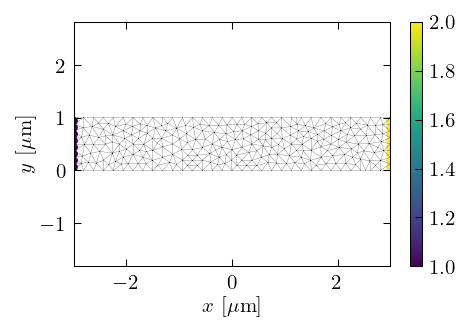

In [4]:
plt.figure()
plt.axis('equal')
geometry.plot()
plt.colorbar()

plt.xlabel(r'$x~[{\rm \mu m}]$')
plt.ylabel(r'$y~[{\rm \mu m}]$')
plt.savefig(output_folder + '/subdomains.pdf')

geometry.check_dimensions()

## Define coefficients

In [5]:
step = create_cellfunction(geometry.mesh, lambda x, y: np.tanh(x))
null = create_cellfunction(geometry.mesh, lambda x, y: 0.)
gauss = create_cellfunction(geometry.mesh, lambda x, y: np.exp(-10*(x-1)**2-10*(y-0.5)**2))
cc = Matrix_Expression(1)
tt = Matrix_Expression(2., dimension = 1, scalar = True)
ct = Matrix_Expression(1, dimension = 2, scalar = True)
L = [[cc,ct],
     [ct,tt]]
Gamma = [[Matrix_Expression(0, dimension = 1, scalar = True),Matrix_Expression(0, dimension = 1, scalar = True)],
         [Matrix_Expression(0, dimension = 1, scalar = True),Matrix_Expression(5, dimension = 1, scalar = True)]]
F = [Matrix_Expression(0, dimension = 1), Matrix_Expression(gauss, dimension = 1)]
#! cc * tt -ct**2 > 0 for L to be positive defined 

In [6]:
cc = Matrix_Expression([[1.,0],
                        [0,1.]], 
                       dimension = 2, scalar = False)
tt = Matrix_Expression(2.)
ct = Matrix_Expression([[lambda x, y: np.tanh(x),lambda x, y: 0.],
                        [lambda x, y: 0.,lambda x, y: np.tanh(x)]], 
                       dimension = 2, scalar = False, mesh = geometry.mesh)

L = [[cc,ct],
     [ct,tt]]

Gamma = [[Matrix_Expression(0),Matrix_Expression(0)],
         [Matrix_Expression(0),Matrix_Expression(5)]]

F = [Matrix_Expression(0), 
     Matrix_Expression(lambda x, y: np.exp(-10*(x-1)**2-10*(y-0.2)**2), 
                       mesh = geometry.mesh, dimension = 1,)]

## Check Seebeck coefficient

Text(0, 0.5, '$y~[{\\rm \\mu m}]$')

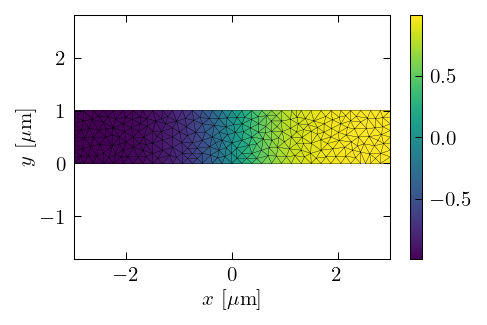

In [7]:
plt.figure()
plt.axis('equal')
plot_mesh(geometry.mesh)
ct.plot(i=0,j=0, mesh = geometry.mesh)
plt.colorbar()
plt.xlabel(r'$x~[{\rm \mu m}]$')
plt.ylabel(r'$y~[{\rm \mu m}]$')

## Solve FEM

In [8]:
problem = Problem(geometry = geometry, n_fields = 2,
                         L = L, 
                         Gamma = Gamma, 
                         contact_resistances = [[1,1],[0,0]],
                         F = F,
                         biases = [[0.,1.],
                                   [0.,0.]]) 
problem.solve()

## Calculate derived quantities

In [9]:
problem.fluxes

array([[ 0.11860474, -0.11860313],
       [-0.11550274, -0.11193039]])

## Plot results

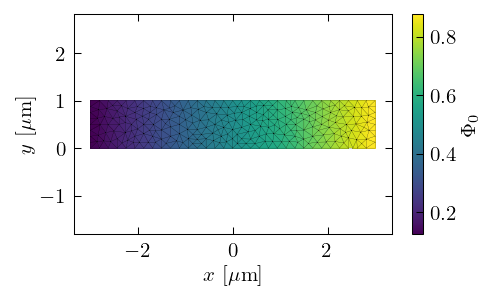

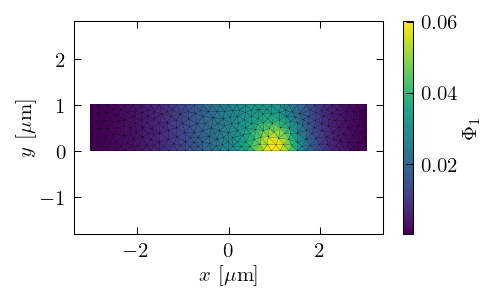

In [10]:
for i in range(problem.n_fields):
    plt.figure()
    plt.axis('equal')
    plt.xlabel(r'$x~[{\rm \mu m}]$')
    plt.ylabel(r'$y~[{\rm \mu m}]$')    
    
    p0,_ = problem.plot_field(i)
    cb = plt.colorbar(mappable=p0)
    #p2 = plot_current(current = problem.currents[i])
    plt.xlim(-3,3)
    cb.set_label(r'$\Phi_{}$'.format(i))
    plt.tight_layout()
    plt.savefig(output_folder +'/constriction{}.pdf'.format(i))

In [11]:
problem.save(output_folder)

In [12]:
print((np.tensordot(problem.response_matrix, problem.biases, axes =2) + problem.source_vector - problem.fluxes)/problem.fluxes)

[[ 4.68034866e-16 -8.65876194e-15]
 [ 6.00755759e-16 -1.02908279e-14]]


(-3.0, 3.0)

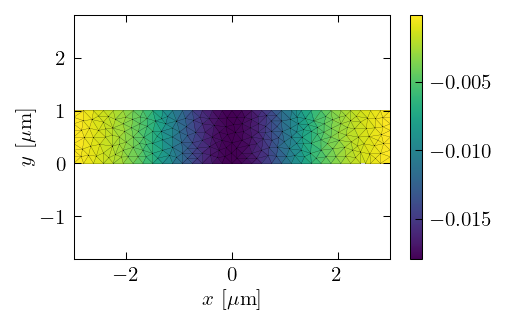

In [13]:
plt.figure()
plt.axis('equal')
plt.xlabel(r'$x~[{\rm \mu m}]$')
plt.ylabel(r'$y~[{\rm \mu m}]$')    

p0,_ = problem.plot_responsivity(flux = 0,contact = 1, source = 1)
cb = plt.colorbar(mappable=p0)
plt.xlim(-3,3)